# Amazon Reviews Classification Using Random Forest and GradientBoosting

In [10]:
%matplotlib inline

import pandas as pd #for data frames
import numpy as np #numpy array operations
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.cross_validation import train_test_split
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,f1_score,precision_score,recall_score,auc,log_loss,confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

from scipy.stats import expon
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
pickle_in=open("cleanedData.pickle","rb")
final = pickle.load(pickle_in)

import pickle
pickle_in = open("BOW_tfidf_avgW2V_Train_test_data.pickle","rb")

count_vect = pickle.load(pickle_in) #BOW
final_counts_train = pickle.load(pickle_in) #BOW
final_counts_test = pickle.load(pickle_in) #BOW
tf_idf_vect = pickle.load(pickle_in) #tfidf
final_tf_idf_train = pickle.load(pickle_in) #tfidf
final_tf_idf_test = pickle.load(pickle_in) #tfidf
features = pickle.load(pickle_in) 
sent_vectors_train = pickle.load(pickle_in) #avgW2v Vectors
sent_vectors_test = pickle.load(pickle_in) #avgW2v Vectors

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
train_data = final.head(int(0.80*final.shape[0]))
test_data = final.head(int(0.20*final.shape[0])+1)

scores = final['Score'].get_values()
len(scores)

364171

In [28]:
def convScores(scores):
    li = lambda x: 1 if x=='positive'  else 0
    final_scores = []
    for i in range(0,len(scores)):
        final_scores.append(li(scores[i]))
    return final_scores

def convToNpArray(arr):
    if(type(arr) == list):
        arr = np.array(arr)
        return arr
    else:
        return arr;
def confusionMatrix(y_test,pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index = ['False','True'],
                      columns = ['False','True'])
    sn.heatmap(df_cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
def auc_roc(y_test,pred):
    fpr, tpr, thresholds = roc_curve(y_test,pred)
    acc = auc(fpr, tpr)
    print("Area Under The Curve is : ",acc)
    plt.figure()

    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area/auc = %0.2f)' % acc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("These are the top {} important Features Which are most widely used in Positive and Negative Reviews:".format(n))
    print("")
    print("\tPositive: \t\t\tNegative:")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("")
        print("\t%-15s\t\t\t%-15s" % (fn_2,fn_1))

# RF

## Avg W2V RF

In [29]:
x_1 = sent_vectors_train[0:50000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:50000]

x_test = sent_vectors_test[0:6000]
y_test = convScores(test_data['Score'].get_values())[0:6000]


x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

#### Considering n_estimators/k and max_depth as hyperparameters

In [30]:
tuned_parameters = {'n_estimators':[10,20,40,50],
                   'max_depth':[20,50,100]}


rf_model = RandomForestClassifier(n_jobs=-1,oob_score=True,class_weight='balanced')
model = GridSearchCV(rf_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Score:  0.882833333333


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


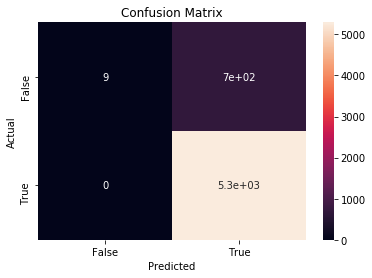

In [31]:
best_rf_model = model.best_estimator_
best_rf_model.fit(x_1,y_1)
pred = best_rf_model.predict(x_test)
confusionMatrix(y_test,pred)

<h5>AUC</h5>

Area Under The Curve is :  0.50131996277


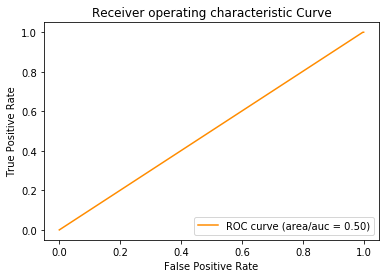

In [16]:
auc_roc(y_test,pred)

## BOW RF

In [33]:
# Total data frame

x_1 = final_counts_train[0:50000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:50000]

x_test = final_counts_test[0:6000]
y_test = convScores(test_data['Score'].get_values())[0:6000]

#x_1, x_test, y_1, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [34]:
tuned_parameters = {'n_estimators':[10,20,40,50],
                   'max_depth':[20,50,100]}


rf_model = RandomForestClassifier(n_jobs=-1,oob_score=True,class_weight='balanced')
model = GridSearchCV(rf_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Score:  0.974


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


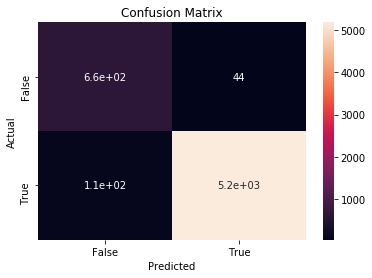

In [35]:
best_rf_model = model.best_estimator_
best_rf_model.fit(x_1,y_1)
pred = best_rf_model.predict(x_test)
confusionMatrix(y_test,pred)

<h5>AUC</h5>

Area Under The Curve is :  0.940581366171


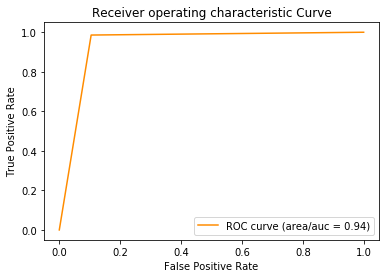

In [21]:
auc_roc(y_test,pred)

In [37]:
show_most_informative_features(count_vect,best_rf_model,10)

These are the top 10 important Features Which are most widely used in Positive and Negative Reviews:

	Positive: 			Negative:

	great          			aa             

	love           			aaa            

	disappoint     			aaaa           

	best           			aaaaa          

	delici         			aaaaaaaaaaaaaa 

	would          			aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

	perfect        			aaaaaaaaaaaaaaaaaaaargh

	wast           			aaaaaaaaagghh  

	favorit        			aaaaaaahhhhhh  

	worst          			aaaaaaarrrrrggghhh


## TFIdf

In [22]:
x_1 = final_tf_idf_train[0:10000]

y_1 = convScores(train_data['Score'].get_values())[0:10000]

x_test = final_tf_idf_test[0:3000]
y_test = convScores(test_data['Score'].get_values())[0:3000]

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [23]:
tuned_parameters = {'n_estimators':[10,20,40,50],
                   'max_depth':[20,50,100]}


rf_model = RandomForestClassifier(n_jobs=-1,oob_score=True,class_weight='balanced')
model = GridSearchCV(rf_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Score:  0.982


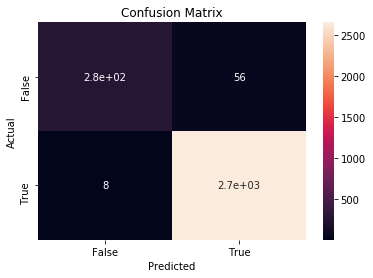

In [24]:
best_rf_model = model.best_estimator_
best_rf_model.fit(x_1,y_1)
pred = best_rf_model.predict(x_test)
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.914667289577


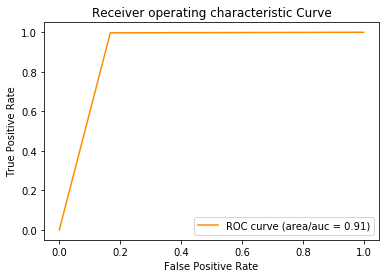

In [25]:
auc_roc(y_test,pred)

## Important Features

In [27]:
show_most_informative_features(tf_idf_vect,best_rf_model,10)

These are the top 10important Features Which are most widely used in Positive and Negative Reviews:

	Positive: 			Negative:

	money          			aa             

	order          			aa pleas       

	return         			aa state       

	great          			aaa            

	horribl        			aaa aaa        

	away           			aaa condit     

	snack          			aaa dont       

	love           			aaa hockey     

	high recommend 			aaa job        

	bland          			aaa magazin    


# GBDT

## Avg W2V

In [48]:
x_1 = sent_vectors_train[0:30000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:30000]

x_test = sent_vectors_test[0:6000]
y_test = convScores(test_data['Score'].get_values())[0:6000]


x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [49]:
tuned_parameters = {'n_estimators':[50,75,100,125],
                   'learning_rate':[0.01,0.1,0.5],
                   'max_depth':[3,5,7]}


#using 70% of data to train the base models (Row Sampling) 
gb_model = GradientBoostingClassifier(subsample=0.7)
model = GridSearchCV(gb_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.7, verbose=0, warm_start=False)
Score:  0.887666666667


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


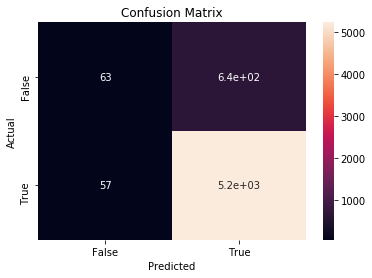

In [50]:
best_gb_model = model.best_estimator_
best_gb_model.fit(x_1,y_1)
pred = best_gb_model.predict(x_test)
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.539169985391


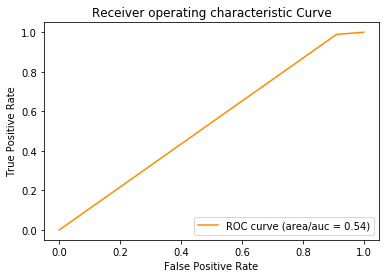

In [51]:
auc_roc(y_test,pred)

### Using XGBClassifier

In [54]:
tuned_parameters = {'n_estimators':[75,100,120],
                   'learning_rate':[0.01,0.1,0.5]}


#using 70% of data to train the base models (Row Sampling) 
gb_model = XGBClassifier(subsample=0.7,n_jobs=4)
model = GridSearchCV(gb_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)
Score:  0.883333333333


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


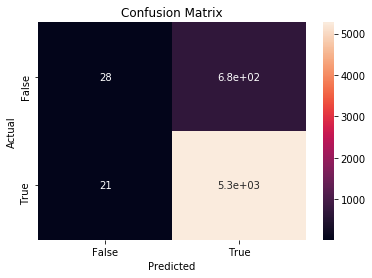

In [55]:
best_gb_model = model.best_estimator_
best_gb_model.fit(x_1,y_1)
pred = best_gb_model.predict(x_test)
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.517818228073


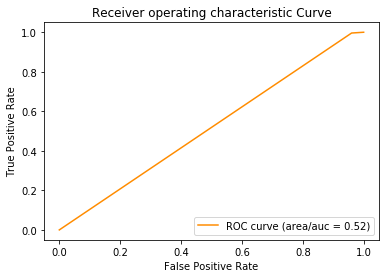

In [56]:
auc_roc(y_test,pred)

# BOW

In [38]:
# Total data frame

x_1 = final_counts_train[0:30000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:30000]

x_test = final_counts_test[0:6000]
y_test = convScores(test_data['Score'].get_values())[0:6000]

#x_1, x_test, y_1, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [39]:
tuned_parameters = {'n_estimators':[75,100,120],
                   'learning_rate':[0.01,0.1,0.5]}


#using 70% of data to train the base models (Row Sampling) 
gb_model = XGBClassifier(subsample=0.7,n_jobs=4)
model = GridSearchCV(gb_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)
Score:  0.9375


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


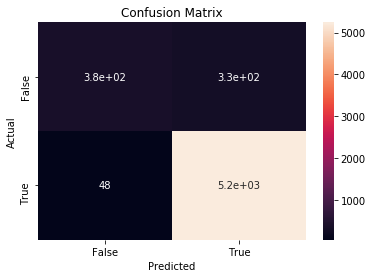

In [40]:
best_gb_model = model.best_estimator_
best_gb_model.fit(x_1,y_1)
pred = best_gb_model.predict(x_test)
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.764206869258


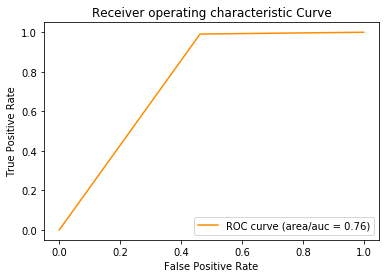

In [41]:
auc_roc(y_test,pred)

## Important Features

In [42]:
show_most_informative_features(count_vect,best_gb_model,10)

These are the top 10 important Features Which are most widely used in Positive and Negative Reviews:

	Positive: 			Negative:

	like           			aa             

	great          			aaa            

	tast           			aaaa           

	product        			aaaaa          

	love           			aaaaaaaaaaaaaa 

	best           			aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

	tri            			aaaaaaaaaaaaaaaaaaaargh

	littl          			aaaaaaaaagghh  

	good           			aaaaaaahhhhhh  

	flavor         			aaaaaaarrrrrggghhh


## TFIdf

In [43]:
x_1 = final_tf_idf_train[0:10000]

y_1 = convScores(train_data['Score'].get_values())[0:10000]

x_test = final_tf_idf_test[0:3000]
y_test = convScores(test_data['Score'].get_values())[0:3000]

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [44]:
tuned_parameters = {'n_estimators':[75,100,120],
                   'learning_rate':[0.01,0.1,0.5]}


#using 70% of data to train the base models (Row Sampling) 
gb_model = XGBClassifier(subsample=0.7,n_jobs=4)
model = GridSearchCV(gb_model,tuned_parameters,
                     scoring='accuracy',cv=3,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Score:  0.961666666667


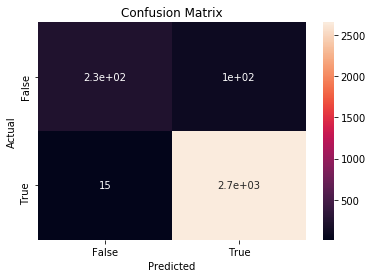

In [45]:
best_gb_model = model.best_estimator_
best_gb_model.fit(x_1,y_1)
pred = best_gb_model.predict(x_test)
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.847486197897


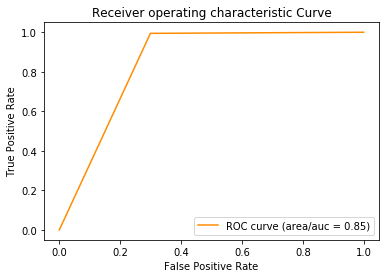

In [46]:
auc_roc(y_test,pred)

## Important Features

In [47]:
show_most_informative_features(tf_idf_vect,best_gb_model,10)

These are the top 10 important Features Which are most widely used in Positive and Negative Reviews:

	Positive: 			Negative:

	good           			aa             

	like           			aa pleas       

	one            			aa state       

	tast           			aaa            

	tri            			aaa aaa        

	product        			aaa condit     

	get            			aaa dont       

	use            			aaa hockey     

	love           			aaa job        

	great          			aaa magazin    


#### Summary:<br>

<table>
    <tr>
        <th>Classifier</th>
        <th>Vectorizer</th>
        <th>Hyper Parameters</th>
        <th>Confusion Matrix</th>
        <th>Accuracy</th>
        <th>AUC</th>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>Avg W2v</td>
        <td>
            n_estimators: 40<br>
            max_depth: 20
        </td>
        <td>
            TPR :0.999622 	 TNR : 0.004243<br>
            FPR : 0.995757 	 FNR: 0.000378
        </td>
        <td>88%<br></td>
        <td>0.5</td>
       
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>BOW</td>
        <td>n_estimators: 40<br>
            max_depth: 50</td>
            
        <td>
            TPR :0.983374 	 TNR : 0.903819<br>
            FPR : 0.096181 	 FNR: 0.016626
        </td>    
        <td>97.5%</td>
        <td>0.94</td>
        
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>TfIdf</td>
        <td>n_estimators: 50<br>
            max_depth: 50</td>
        <td>
            TPR :0.999625 	 TNR : 0.847305<br>
            FPR : 0.152695 	 FNR: 0.000375
        </td>
        <td>97.9%</td>
        <td>0.91</td>
    </tr>
    <tr>
        <td>Gradient Boost / XGBClassifier</td>
        <td>Avg W2v</td>
        <td>
            n_estimators: 100<br>
            learning_rate: 0.1<br>
            max_depth: 7<br>
            
            <b>Using XGBClassifier</b><br>
            n_estimators: 120<br>
            learning_rate: 0.1
        </td>
        <td>
            TPR :0.983374 	 TNR : 0.128713<br>
            FPR : 0.871287 	 FNR: 0.016626
        </td>
        <td>88.33%</td>
        <td>0.54</td>
       
    </tr>
    <tr>
        <td>Gradient Boost / XGBClassifier</td>
        <td>BOW</td>
        <td>n_estimators: 120<br>
            learning_rate: 0.5</td>
        <td>
            TPR :0.990931 	 TNR : 0.537482<br>
            FPR : 0.462518 	 FNR: 0.009069
        </td>
        <td>93.75%</td>
        <td>0.76</td>
    </tr>
    <tr>
        <td>Gradient Boost / XGBClassifier</td>
        <td>TfIdf</td>
        <td>n_estimators: 120<br>
            learning_rate: 0.5<br></td>
        <td>
            TPR :0.994374 	 TNR : 0.700599<br>
            FPR : 0.299401 	 FNR: 0.005626
        </td>
        <td>96.2%</td>
        <td>0.85</td>
    </tr>
</table>



-> With Both the classifiers BOW and Tfidf have given Good Results in terms of TPR TNR and Accuracy.<br>
-> Even Interms of AUC also BOW and Tfidf Have performed well.<br>
-> Interms of AUC Random Forest has Performed well when compared to Gradient Boost.<br>

Note: <br>
-> Didnt use Sklearn's GradientBoost Classifier for Tfidf and BOW because fit() method is expecting dense array, as there is large amount of data with more no.of dimensions it requires more Memory, So used XGBClassifier().<br>

-> XGBClassifier took very Less time to execute when compared to GradientBoostingClassifier() because XGBClassifier supports Parallel Execution. 